In [1]:
import tensorflow as tf
from keras.utils import multi_gpu_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Nadam, SGD
from keras.models import Model, load_model
from keras.layers import GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator
from efficientnet.preprocessing import preprocess_input
from efficientnet import model
from PIL import ImageFile
import os
import math

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
ImageFile.LOAD_TRUNCATED_IMAGES = True
print('Tensorflow', tf.__version__)

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

/home/eleven/Pranav/tf12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/eleven/Pranav/tf12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/eleven/Pranav/tf12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/eleven/Pranav/tf12/lib/python3.6/site-packages/tensorflow/python/frame

Tensorflow 1.14.0


In [2]:
train_path = 'train/'
test_path = 'val/'

lr = 2e-5
batch_size = 16
img_height, img_width = 299, 299
classes = 4

In [3]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=30,
    shear_range=0.5,
    zoom_range=.7,
    channel_shift_range=0.3,
    cval=0.5,
    vertical_flip=False,
    brightness_range=[0.1,0.7],
    fill_mode='nearest')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 3084 images belonging to 4 classes.
Found 773 images belonging to 4 classes.


In [4]:
model_path = 'model/'
top_weights_path = os.path.join(
    os.path.abspath(model_path), 'top_model_weights_efficient.h5')
final_weights_path = os.path.join(
    os.path.abspath(model_path), 'model_weights_efficient.h5')

In [27]:
callbacks_list = [ModelCheckpoint(final_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
                  EarlyStopping(monitor='val_loss', patience=5, verbose=1)]

efficient = model.EfficientNetB5(include_top=False, weights='imagenet',
                    input_shape=(img_height, img_width, 3), pooling = 'avg')
x = efficient.output
x = Dense(classes, activation='softmax')(x)
module = Model(inputs=efficient.input, outputs=x)

In [32]:
module.compile(optimizer=Nadam(
    lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = module.fit_generator(train_generator,
                              steps_per_epoch=train_generator.__len__(),
                              epochs=50,
                              validation_data=test_generator,
                              validation_steps=test_generator.__len__(),
                              use_multiprocessing=False,
                              callbacks=callbacks_list)

In [ ]:
# Fine Tuning

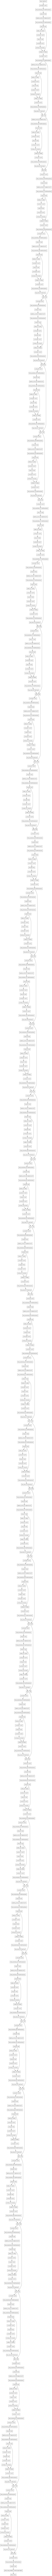

In [28]:
tf.keras.utils.plot_model(module)

In [30]:
[x.name for x in module.layers].index('add_124')

526

In [31]:
unfreeze = 526
for layer in module.layers[:-unfreeze]:
    layer.trainable = False

for layer in module.layers[-unfreeze:]:
    layer.trainable = True

In [ ]:
# load model

In [ ]:
from keras.models import load_model
import efficientnet
_ = efficientnet.model.EfficientNetB5() # Model used for training
model = load_model('model/model_weights_efficient.h5')